In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

In [4]:
X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)

In [5]:
df = X_train_observed_a.copy()

df.index = pd.to_datetime(df.index)

grouped = df.groupby(df.index.date)

def time_difference_from_max_solar_elevation(group):
    time_of_max_solar_elevation = group['sun_elevation:d'].idxmax()
    time_difference = (group.index - time_of_max_solar_elevation).seconds / 3600
    time_difference = time_difference - (time_difference > 12) * 24  # Adjust for differences more than 12 hours
    return pd.Series(time_difference, index=group.index)

# Apply the function to each group
time_difference = grouped.apply(time_difference_from_max_solar_elevation)

# Flatten the resulting multi-index
time_difference = time_difference.reset_index(level=0, drop=True)


In [6]:
time_difference = time_difference.to_frame()

How should i pick the models i want to use?

Is there any point in having specialized models?

The based to collect the models
 - How should i weight them?
    - Not according to MAE on Kaggle?

 Should i fit the dataset only on a subset of the data?

How bad can the worst model in the ensemble be?

Any point in bagging/stacking?

Benefits of regularized greedy forest?

Trasformer architecture?

Is there such a thing as too much tuning?

In [7]:
time_difference.head()

,date_forecast
date_forecast,
2019-06-02 22:00:00,0.00
2019-06-02 22:15:00,0.25
2019-06-02 22:30:00,0.50
2019-06-02 22:45:00,0.75
2019-06-02 23:00:00,1.00


In [8]:
train_a.set_index('time', inplace=True)

<Axes: xlabel='time'>

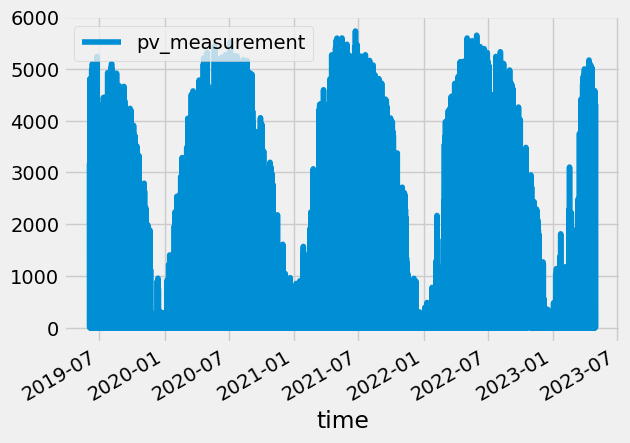

In [9]:
train_a.plot()

<Axes: xlabel='time'>

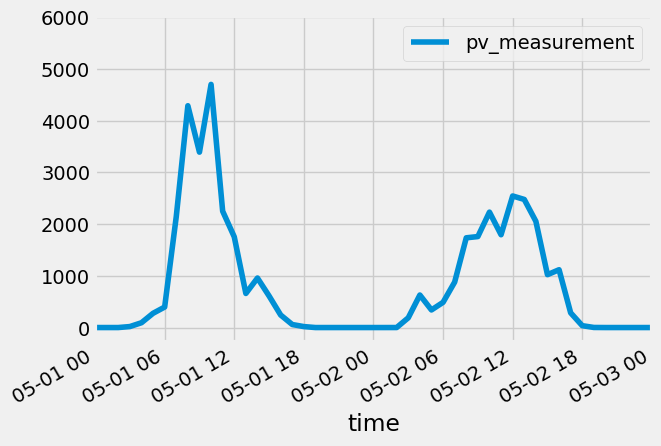

In [10]:
train_a.plot(xlim=('2020-05-01 00:00', '2020-05-03 00:00'))

In [11]:
train_a.head(50)

,pv_measurement
time,
2019-06-02 22:00:00,0.00
2019-06-02 23:00:00,0.00
2019-06-03 00:00:00,0.00
2019-06-03 01:00:00,0.00
2019-06-03 02:00:00,19.36
2019-06-03 03:00:00,251.02
2019-06-03 04:00:00,263.78
2019-06-03 05:00:00,522.72
2019-06-03 06:00:00,904.42


In [12]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10